For investigating the output of run `06` where we are using the second version of the physically motivated $w$ starting position. Make four plots
1. Convergence plots of suboptimizations
2. Feasibility criterion
3. Globally averaged weights
4. Monthly weigh maps

Code borrowed from `./output_investigation_05.ipynb`.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.optimize import minimize

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

In [4]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [5]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/na_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [6]:
# psi_alpha
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

In [7]:
def f_w(w, y=y_obs, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return np.dot(w, y) - psi_alpha * np.linalg.norm(w) - np.dot(b, c)

# Plotting functions

In [8]:
def global_avg_plot(w_ser, title_str=None):
    """
    Globally averaged weights at daily, weekly, and month res
    
    Parameters
    ----------
        w_ser (pandas series) : weights indexed by time
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
    ts_day = w_ser.resample('D').mean()
    ts_week = w_ser.resample('W').mean()
    ts_month = w_ser.resample('M').mean()
    ts_day.plot(ax=ax, label='Day')
    ts_week.plot(ax=ax, label='Week')
    ts_month.plot(ax=ax, label='Month')
    ax.axhline(0, linestyle='--', color='gray')
    ax.legend()
    ax.set_title(title_str)
    plt.show()
    
def month_map_plot(df, w_col_str, norm, vmin=None, vmax=None):
    """
    Monthly heat maps for the given weights
    
    Parameters
    ----------
        df        (pandas dataframe)  : contains columns - 'month', 'lon', 'lat', and w_col_str
        w_col_str (str)               : name of w column in df to use
        norm      (mcolors.Normalize) : for color scheme
    """
    # w start
    fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(12, 16))
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

    for i in range(8):
        row_idx = i // 2
        col_idx = i % 2
        month_idxs = df['month'].astype(int) == i + 1
        sp_i = ax[row_idx, col_idx].scatter(
            df['lon'][month_idxs], df['lat'][month_idxs],
            c=df[w_col_str][month_idxs],
            norm=norm, vmin=vmin, vmax=vmax,
            s=14
        )
        ax[row_idx, col_idx].set_title(months[i])

    plt.colorbar(sp_i,ax=ax[0, 0])
    plt.show()

# Optimization diagnostics

#### Convergence Plots

In [10]:
# read in the raw stdout file
with open(BASE_DIR + '/06/stdout_it0_1.txt', 'r') as f:
    stdout0_1_raw = f.readlines()

In [13]:
# isolate the trajectories from the w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout0_1_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:13]
traj_c_01 = all_obj_vals[13:16]
traj_w_02 = all_obj_vals[16:29]
traj_c_02 = all_obj_vals[29:]

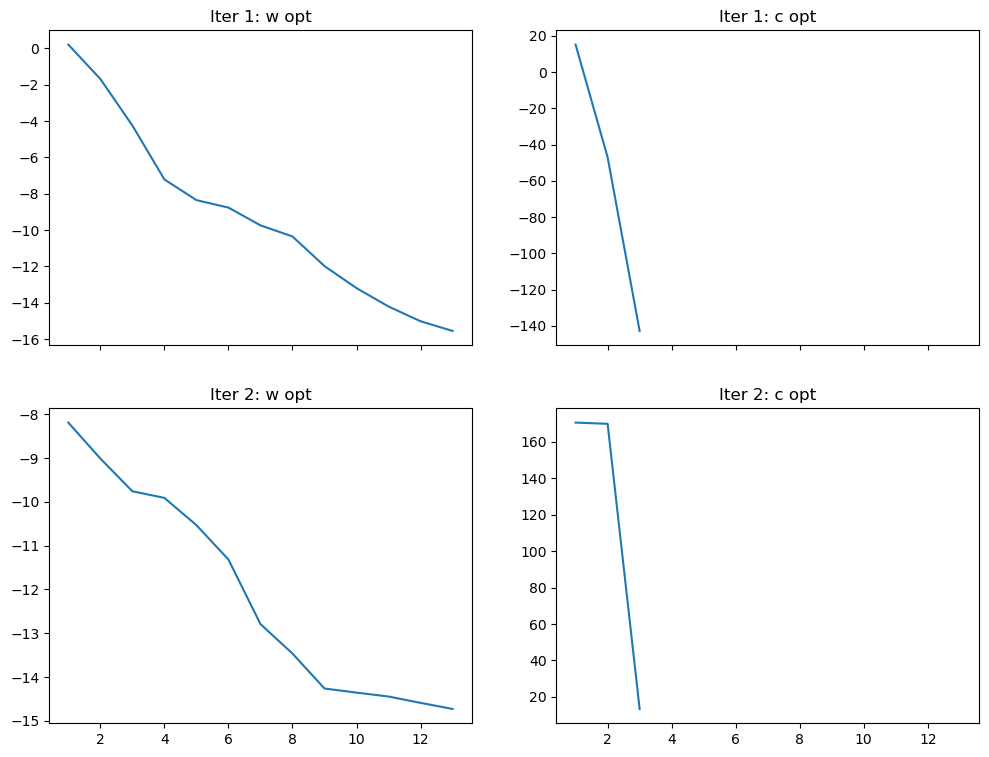

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 9), sharex=True)

# plots
ax[0, 0].plot(np.arange(1, len(traj_w_01) + 1), traj_w_01)
ax[0, 1].plot(np.arange(1, len(traj_c_01) + 1), traj_c_01)
ax[1, 0].plot(np.arange(1, len(traj_w_02) + 1), traj_w_02)
ax[1, 1].plot(np.arange(1, len(traj_c_02) + 1), traj_c_02)

# labels
ax[0, 0].set_title('Iter 1: w opt')
ax[0, 1].set_title('Iter 1: c opt')
ax[1, 0].set_title('Iter 2: w opt')
ax[1, 1].set_title('Iter 2: c opt')

plt.show()

#### Final Results

In [15]:
with open(BASE_DIR + '/06/final_results.pkl', 'rb') as f:
    final_res = pickle.load(f)

In [16]:
final_res

{'objective_evals': [318.95143765083156, 3.0483452358722425],
 'w_opt_output': {'vectors': array([[-3.61177682e-04,  2.67143048e-03, -1.63589922e-04, ...,
          -4.06091535e-04, -4.95763707e-04,  2.19275232e-03],
         [-4.01010065e-04,  2.96604846e-03, -1.81816167e-04, ...,
          -3.17689991e-05, -3.01266351e-05,  3.24600594e-03]]),
  'status': array([0., 0.]),
  'nfev': array([14., 14.]),
  'njev': array([0., 0.])},
 'c_opt_output': {'vectors': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'status': array([1., 1.]),
  'nfev': array([3., 4.]),
  'njev': array([0., 0.])},
 'lambda_opt_output': {'vectors': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])},
 'KTw_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

#### Feasibility

In [17]:
# get feasibility values for each ADMM iteration
NUM_ITERS = len(final_res['objective_evals'])
feasibility_vals = [
    np.linalg.norm(h + A.T @ final_res['c_opt_output']['vectors'][i] - final_res['KTw_vecs'][i])
    for i in range(NUM_ITERS)
]
print(feasibility_vals)

[0.566651179036465, 0.04569348389385766]


# Weight plots

In [18]:
# read in the starting w used
with open('./data/carbon_flux/results/06/intermediate_starts/w_start_it0.npy', 'rb') as f:
    w_start = np.load(file=f)

In [19]:
# add columns to the gosat dataframe
gosat_df['w_start'] = w_start
gosat_df['w_admm0'] = final_res['w_opt_output']['vectors'][0, :]
gosat_df['w_admm1'] = final_res['w_opt_output']['vectors'][1, :]

In [20]:
# create a datetime column for the observations
gosat_df['time'] = gosat_df.apply(
    lambda x: pd.to_datetime(f"{int(x['day'])}/{int(x['month'])}/{int(x['year'])}", format="%d/%m/%Y"),
    axis=1
)

# set the above as the index
gosat_df.set_index('time', inplace=True)

#### Global Average Weights

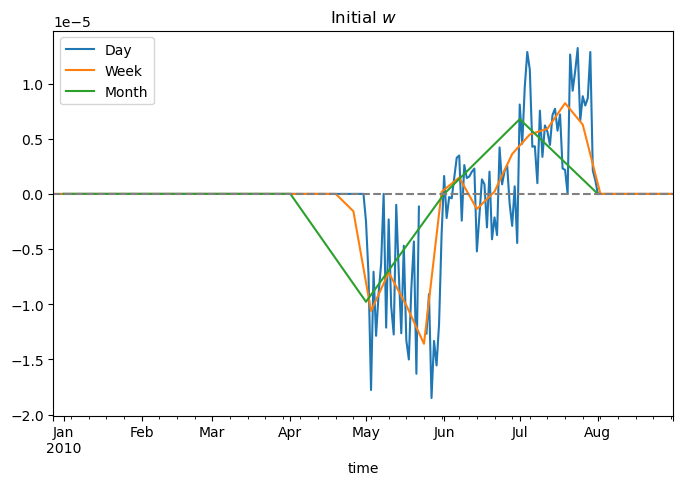

In [21]:
global_avg_plot(w_ser=gosat_df['w_start'], title_str=r'Initial $w$')

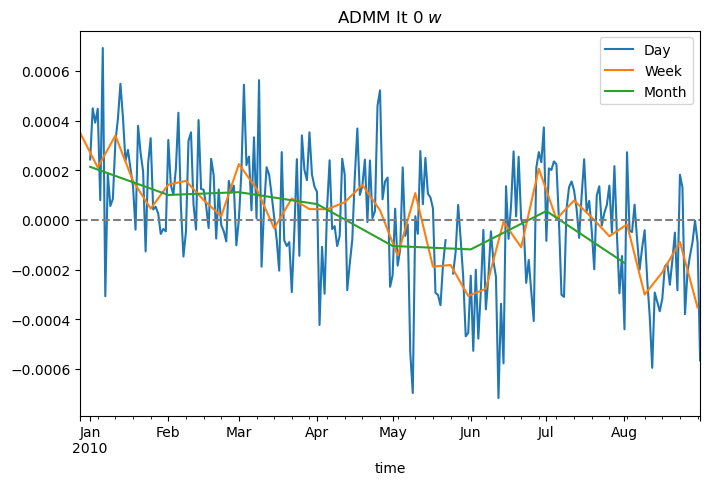

In [22]:
global_avg_plot(w_ser=gosat_df['w_admm0'], title_str=r'ADMM It 0 $w$')

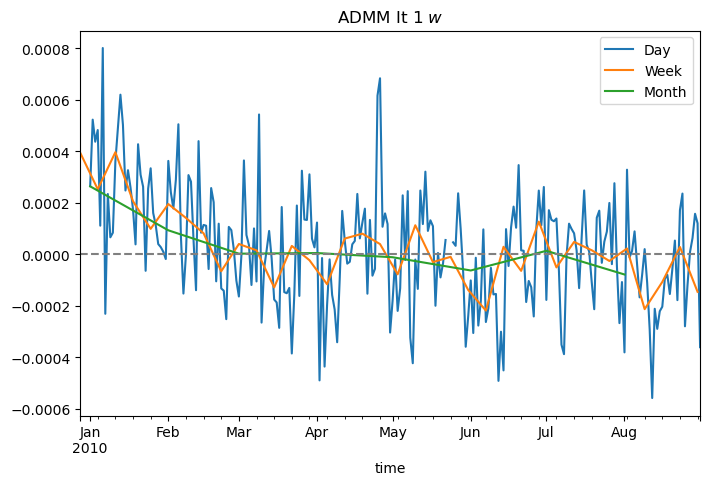

In [23]:
global_avg_plot(w_ser=gosat_df['w_admm1'], title_str=r'ADMM It 1 $w$')

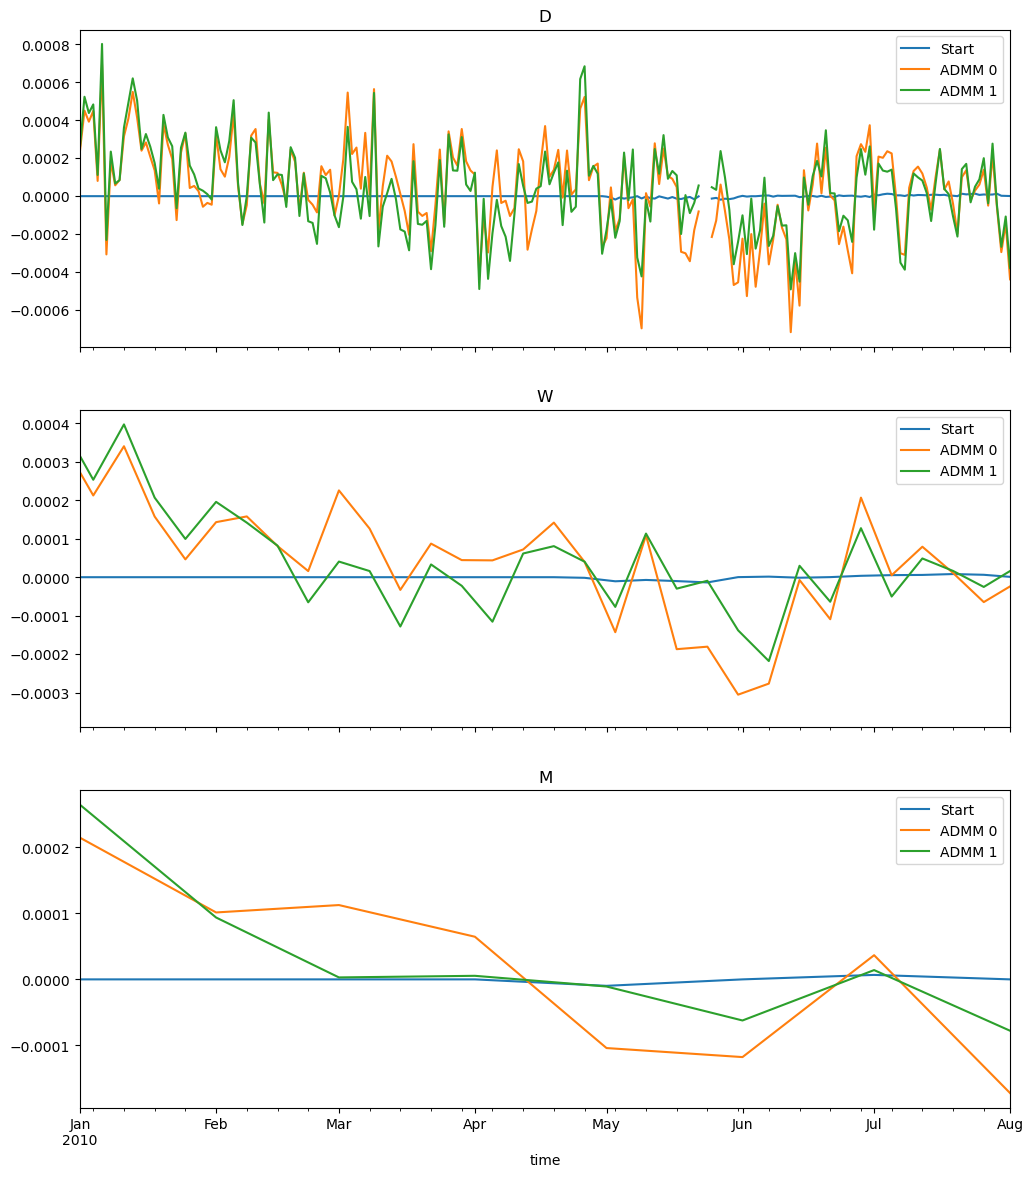

In [24]:
# plots of daily, weekly, and month means
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(12, 14), sharex=True)
resample_vals = ['D', 'W', 'M']

for i in range(3):
    ts_start = gosat_df['w_start'].resample(resample_vals[i]).mean()
    ts_0 = gosat_df['w_admm0'].resample(resample_vals[i]).mean()
    ts_1 = gosat_df['w_admm1'].resample(resample_vals[i]).mean()
    ts_start.plot(ax=ax[i], label='Start')
    ts_0.plot(ax=ax[i], label='ADMM 0')
    ts_1.plot(ax=ax[i], label='ADMM 1')
    ax[i].legend()
    ax[i].set_title(resample_vals[i])

plt.show()

#### Monthly Heat Maps

In [25]:
# define a color scheme
norm_start = mcolors.Normalize(
    vmin=gosat_df['w_start'].min(),
    vmax=gosat_df['w_start'].max(),
)
norm = mcolors.Normalize(
    vmin=gosat_df[['w_start', 'w_admm0', 'w_admm1']].values.flatten().min(),
    vmax=gosat_df[['w_start', 'w_admm0', 'w_admm1']].values.flatten().max(),
)

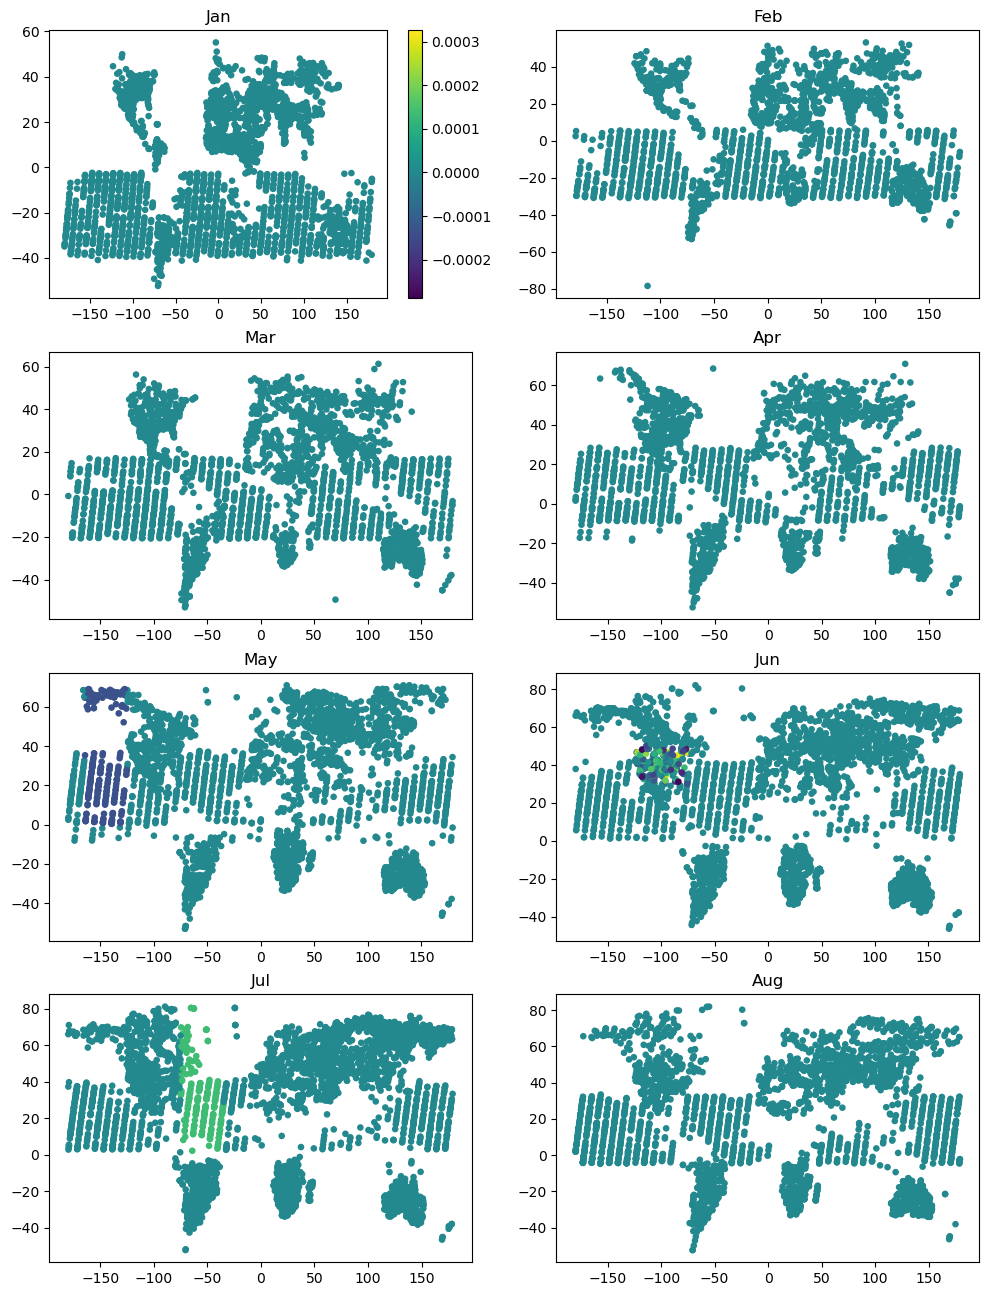

In [26]:
# initial w
month_map_plot(df=gosat_df, w_col_str='w_start', norm=norm_start)

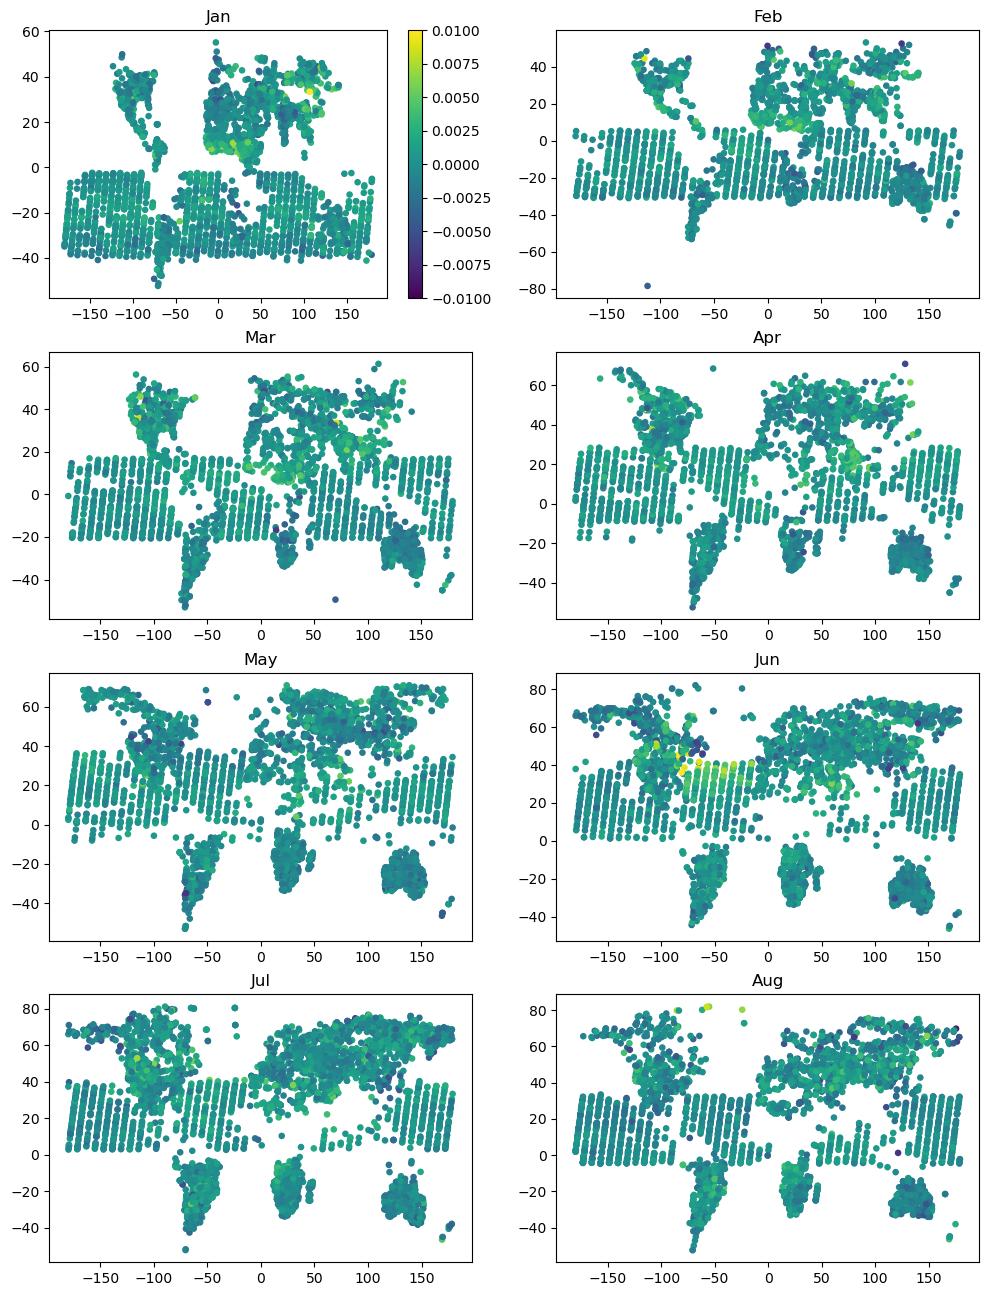

In [27]:
# after one ADMM iteration
month_map_plot(df=gosat_df, w_col_str='w_admm0', norm=None, vmin=-0.01, vmax=0.01)

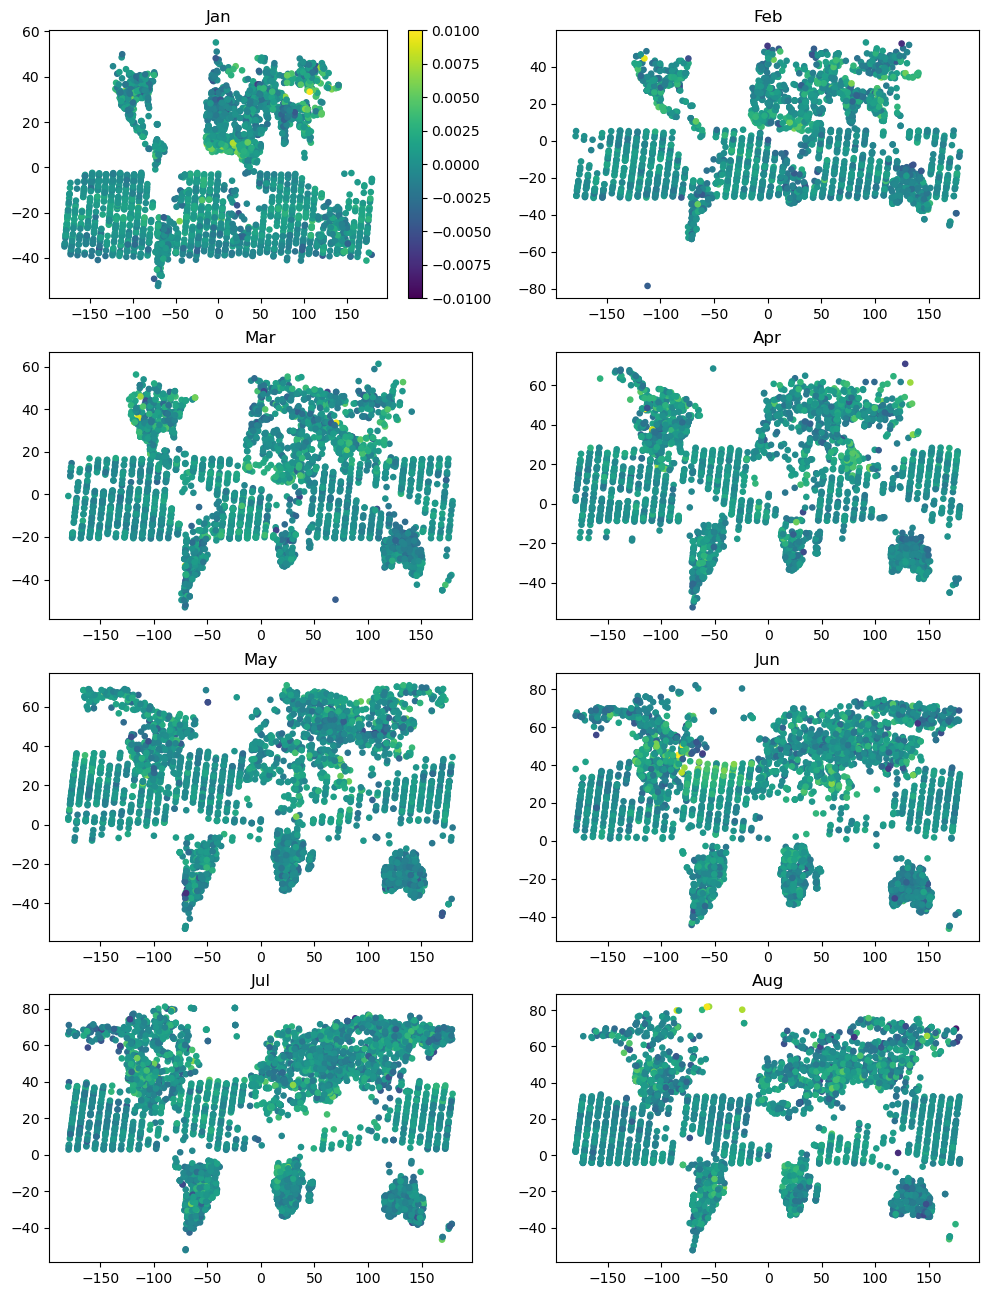

In [28]:
# after one ADMM iteration
month_map_plot(df=gosat_df, w_col_str='w_admm1', norm=None, vmin=-0.01, vmax=0.01)

# Create new starting positions

In [29]:
SAVE_BASE = '/Users/mikestanley/Research/Carbon_Flux/optimization/src_admm'
SAVE_BASE += '/data/carbon_flux/results/06/intermediate_starts'

In [36]:
# saving w starting position
with open(SAVE_BASE + '/w_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['w_opt_output']['vectors'][1])
    
# saving c starting position
with open(SAVE_BASE + '/c_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['c_opt_output']['vectors'][1])
    
# saving lambda starting position
with open(SAVE_BASE + '/lambda_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['lambda_opt_output']['vectors'][1])